# Jupyter notebook to reproduce some of the results of Chapter 2 of the thesis (the remaining codes can be asked from Lumen Eek)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as intg
from scipy import linalg as scpal
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import ListedColormap
from copy import copy
from tqdm import tqdm

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
def depcreutz(a,b,t1,t2,t3,w,N,BC="open"):
    """SSH reduced Creutz model: 4bands. a is the on-site gain/loss of the two sites over which we reduce, b is another on-site
    gain/loss in the other two sites. t1,t2,t3 are hoppings between sites with a's and b's, w is the intercell hopping and N
    is the number of unit cells."""
    
    H=np.zeros([4*N,4*N], dtype=np.complex128)
    Hcell=np.array([[1j*a, t1, t2, 1j*t2], [t1, 1j*b, -1j*t3, t2], [t2, 1j*t3, 1j*b, t1], [-1j*t2, t2, t1, 1j*a]])
    
    for i in range(N):
        H[4*i:4*(i+1), 4*i:4*(i+1)]=Hcell
        if i<N-1:
            H[4*i:4*(i+1), 4*(i+1):4*(i+2)]=np.array([[0,0,0,0], [0,0,0,0], [0,0,0,0], [w,0,0,0]])
            H[4*(i+1):4*(i+2), 4*i:4*(i+1)]=np.array([[0,0,0,w], [0,0,0,0], [0,0,0,0], [0,0,0,0]])
            
    if BC=="periodic":
        H[0,4*N-1]=w
        H[4*N-1,0]=w
    return H

def HNcreutz(a,b,t1,t2,t3,N,BC="open"):
    """HN reduced Creutz model: 3bands."""
    
    H=np.zeros([3*N,3*N], dtype=np.complex128)
    Hcell=np.array([[1j*a, t2, t1], [t2, 1j*b,+1j*t3], [t1, -1j*t3, 1j*b]])
    for i in range(N):
        H[3*i:3*(i+1), 3*i:3*(i+1)]=Hcell
        if i<N-1:
            H[3*i:3*(i+1), 3*(i+1):3*(i+2)]=np.array([[1j*t2,0,0], [0,0,0], [t2,0,0]])
            H[3*(i+1):3*(i+2), 3*i:3*(i+1)]=np.array([[-1j*t2,0,t2], [0,0,0], [0,0,0]])
            
    if BC=="periodic":
        H[0,3*N-1]=t2
        H[0,3*N-3]=1j*t2
        H[3*N-1,0]=t2
        H[3*N-3,0]=-1j*t2
    return H

def getspect(H):
    """Obtain sorted (in terms of abs) eigenvalues and corresponding eigenvectors of the Hamiltonian H. """
    eig= scpal.eig(H, left=True)
    idx = np.abs(eig[0]).argsort()
    eigval = eig[0][idx]
    vl= eig[1][:,idx]
    vr= eig[2][:,idx]
    return (eigval, vl, vr)

def pltedge(E, E0, pl, pr):
    """Finds and plots the edge states at the energy E0 from right and left eigenstates pl, pr and spectrum E"""
    
    Pnh=np.sqrt(np.conjugate(pl)*pr)
    plt.figure(figsize=(8,5))
    Y=np.abs(Pnh)[:,np.where(np.abs(E-(E0))<1e-3)[0]]
    plt.plot(Y);
    plt.ylabel("$\\left|\\sqrt{\psi_L^*\psi_R}\\right|$", fontsize=15);
    plt.xlabel("$x$", fontsize=15);
    plt.text(len(Pnh)/4, 2*np.max(Y[:,0])/3, "$E_0=%.2f+%.2fi$" %(np.real(E0), np.imag(E0)) , fontsize=20);
    return None

def Ecrit(a,b,t1,t2,t3):
    """Determine the critical energies of the topological phase transitions of the SSH Creutz four-band model"""
    
    A=-1j*(a+2*b)
    B=-(t1**2+t2**2+t3**2+2*a*b+b**2)
    C=1j*(a*t3**2+b*(t1**2+t2**2)+a*b**2)

    Exp1=(A**2-3*B)/(-2*A**3+9*A*B+3*(-9*C+np.sqrt(-3*(A**2-4*B)*B**2+6*A*(2*A**2-9*B)*C+81*C**2)))**(1/3)
    Exp2=(-2*A**3+9*A*B+3*(-9*C+np.sqrt(-3*(A**2-4*B)*B**2+6*A*(2*A**2-9*B)*C+81*C**2)))**(1/3)

    E01=1/6*(-2*A+2*2**(1/3)*Exp1+2**(2/3)*Exp2);
    E02=1/12*(-4*A-4*(-2)**(1/3)*Exp1+2*(-2)**(2/3)*Exp2);
    E03=-A/3+(-1)**(2/3)*2**(1/3)/3*Exp1-1/3*(-1/2)**(1/3)*Exp2;

    Ec=np.asarray([E01,E02,E03]);
    
    return Ec

def vg(a,b,t1,t2,t3,E):
    """Calculate v and g of the 3 and 4 band models"""
    
    v=2*t1*t2*(E-1j*b)/((E-1j*b)**2-t3**2)
    g=-1j*(t1**2*t3+t2*t3*(t3-t2)-t2*(E-1j*b)**2)/((E-1j*b)**2-t3**2)
    
    return (v,g)

def wcrit(a,b,t1,t2,t3,Ec):
    """Calculate the critical intercell hopping at topological phase transition of the 4 band model"""
    
    v=2*t1*t2*(Ec-1j*b)/((Ec-1j*b)**2-t3**2)
    g=-1j*(t1**2*t3+t2*t3*(t3-t2)-t2*(Ec-1j*b)**2)/((Ec-1j*b)**2-t3**2)

    wc=np.sqrt(np.abs(v**2-g**2));
    
    return wc

def Tpm(pm,b,t1,t2,t3,Er,Ei):
    """Calculate Tp=v+g and Tm=v-g of the 3 and 4 band models, as a function of E_real and E_imag"""
    
    T=np.zeros([len(Er),len(Ei)], dtype=np.complex128)
    for i in range(len(Er)):
        for j in range(len(Ei)):
            E=Er[i]+1j*Ei[j]
#             v=2*t1*t2*(Er[i]+1j*Ei[j]-1j*b)/((Er[i]+1j*Ei[j]-1j*b)**2-t3**2)
#             g=-1j*(t1**2*t3+t2*t3*(t3-t2)-t2*(Er[i]+1j*Ei[j]-1j*b)**2)/((Er[i]+1j*Ei[j]-1j*b)**2-t3**2)
            v = (2j*t1*t2*(b+1j*E))/((b+1j*E)**2 + t3**2)
            g = 1j*(-t2*t3*(t2-t3)+t2*(b+1j*E)**2+t3*t1**2)/((b+1j*E)**2 + t3**2)
    
            T[i,j]=v+(-1)**pm*g
    
    return T

def TT(pm,b,t1,t2,t3,E):
    """Calculate Tp=v+g and Tm=v-g of the 3 and 4 band models at the specific energy E"""
    
    v = (2j*t1*t2*(b+1j*E))/((b+1j*E)**2 + t3**2)
    g = 1j*(-t2*t3*(t2-t3)+t2*(b+1j*E)**2+t3*t1**2)/((b+1j*E)**2 + t3**2)
    
#     v=2*t1*t2*(E-1j*b)/((E-1j*b)**2-t3**2)
#     g=-1j*(t1**2*t3+t2*t3*(t3-t2)-t2*(E-1j*b)**2)/((E-1j*b)**2-t3**2)
    
    T=v+(-1)**pm*g
    
    return T

def Ecurve(x,b,t1,t2,t3):
    """Kappa=Zero contour in the energy landscape"""
    
    yp=b+1/t2*np.sqrt(-t2*(t1**2*t3+t2*(-t2*t3+t3**2+x**2)))
    ym=b-1/t2*np.sqrt(-t2*(t1**2*t3+t2*(-t2*t3+t3**2+x**2)))
    yb=np.full((len(x),1),b)
    return (yb,yp,ym)

def uglycreutz8(a,b,t1,t2,t3,t,w,N,BC="open"):
    """Ugly Creutz model with  'cloud-shaped' graph of 8 sites, connected to the sites over which we do ISR. a is the on-site 
    gain/loss of the two sites over which we reduce, b is another on-site gain/loss on the two connecting sites of the cloud.
    t1,t2,t3 are hoppings between sites with a's and b's, while t is hopping inside the cloud. w is the intercell hopping and N
    is the number of unit cells."""
    
    Ns=10 # number of sites in unit cell
    H=np.zeros([Ns*N,Ns*N], dtype=np.complex128)
    Hcell=np.array(
[[1j*a, 0, 0, t1, t2, 0, 0, 0, 0, 0], [0, 0, 0, 0, t, 0, t, 0, 0, 
  0], [0, 0, 0, 0, 0, t, t, t, 0, 0], [t1, 0, 0, 1j*b, -1j*t3, 0, t, 0, 
  t, t2], [t2, t, 0, 1j*t3, 1j*b, 0, 0, t, 0, t1], [0, 0, t, 0, 0, 0, 0,
   t, t, 0], [0, t, t, t, 0, 0, 0, 0, 0, 0], [0, 0, t, 0, t, t, 0, 0, 
  t, 0], [0, 0, 0, t, 0, t, 0, t, 0, 0], [0, 0, 0, t2, t1, 0, 0, 0, 0,
   1j*a]])
    
    for i in range(N):
        H[Ns*i:Ns*(i+1), Ns*i:Ns*(i+1)]=Hcell
        zer=[0,0,0,0,0,0,0,0,0,0]
        W1=[w,0,0,0,0,0,0,0,0,0]
        W2=[0,0,0,0,0,0,0,0,0,w]
        if i<N-1:
            H[Ns*i:Ns*(i+1), Ns*(i+1):Ns*(i+2)]=np.array([zer, zer, zer, zer, zer, zer, zer, zer, zer, W1])
            H[Ns*(i+1):Ns*(i+2), Ns*i:Ns*(i+1)]=np.array([W2, zer, zer, zer, zer, zer, zer, zer, zer, zer])
            
    if BC=="periodic":
        H[0,Ns*N-1]=w
        H[Ns*N-1,0]=w
    return H

def TT10(pm,a,b,t1,t2,t3,t,e):
    """Calculate Tp=v+g and Tm=v-g for the 10-band models, at specific E"""
    
    v = (2*e + 2*t)*(e**6*t1*t2 + e**5*t1*t2*(-1j*b - t) + 1j*e**4*t*t1*t2*(b + 8*1j*t) + e**3*t**2*(6*1j*b*t1*t2 + 
        t*(t1**2 + 4*t1*t2 + t2**2)) + 2*e**2*t**3*t1*t2*(-1j*b + 7*t) - 3*e*t**4*(2*1j*b*t1*t2 + t*(t1 + t2)**2) + 
        t**6*(t1 - t2)**2)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 
        4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 
        10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8);
    
    g = -1j*e*t3*(e + t)**2*(t1 - t2)*(t1 + t2)*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 
        4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + 
        e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - 
        e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8)
    
    T=v+(-1)**pm*g
    
    return T

def tt10(pm,a,b,t1,t2,t3,t,Er,Ei):
    """Calculate Tp=v+g and Tm=v-g for the 10-band models, as a function of E_real and E_imag"""
    
    T=np.zeros([len(Er),len(Ei)], dtype=np.complex128)
    for i in range(len(Er)):
        for j in range(len(Ei)):
            e=Er[i]+1j*Ei[j];
            
            v = (2*e + 2*t)*(e**6*t1*t2 + e**5*t1*t2*(-1j*b - t) + 1j*e**4*t*t1*t2*(b + 8*1j*t) + e**3*t**2*(6*1j*b*t1*t2 + 
                t*(t1**2 + 4*t1*t2 + t2**2)) + 2*e**2*t**3*t1*t2*(-1j*b + 7*t) - 3*e*t**4*(2*1j*b*t1*t2 + t*(t1 + t2)**2) + 
                t**6*(t1 - t2)**2)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 
                4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 
                10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8);
    
            g = -1j*e*t3*(e + t)**2*(t1 - t2)*(t1 + t2)*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 
                4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + 
                e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - 
                e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8)
    
            T[i,j]=v+(-1)**pm*g
    
    return T

def w10crit(a,b,t1,t2,t3,t,e):
    """Calculate the critical intercell hopping at topological phase transition of the 10 band model"""
    
    v = (2*e + 2*t)*(e**6*t1*t2 + e**5*t1*t2*(-1j*b - t) + 1j*e**4*t*t1*t2*(b + 8*1j*t) + e**3*t**2*(6*1j*b*t1*t2 + 
        t*(t1**2 + 4*t1*t2 + t2**2)) + 2*e**2*t**3*t1*t2*(-1j*b + 7*t) - 3*e*t**4*(2*1j*b*t1*t2 + t*(t1 + t2)**2) + 
        t**6*(t1 - t2)**2)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 
        4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 
        10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8);
    
    g = -1j*e*t3*(e + t)**2*(t1 - t2)*(t1 + t2)*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3)/(-b**2*e*(e + t)**2*(e**3 - 2*e**2*t - 
        4*e*t**2 + 6*t**3) - 2*1j*b*(e**7 - 9*e**5*t**2 - 4*e**4*t**3 + 18*e**3*t**4 + 8*e**2*t**5 - 8*e*t**6 - 2*t**7) + 
        e**8 - 11*e**6*t**2 - 4*e**5*t**3 + 32*e**4*t**4 + 10*e**3*t**5 - 32*e**2*t**6 - 4*e*t**7 - 
        e*t3**2*(e + t)**2*(e**3 - 2*e**2*t - 4*e*t**2 + 6*t**3) + 8*t**8)

    wc=np.sqrt(np.abs(v**2-g**2));
    
    return wc

def Ecrit10(a, b, t1, t2, t3, t):
    """Determine the critical energies of the topological phase transitions of the SSH Creutz ten-band model"""

    c0=4*(-a)*(b*t**7 - 2*1j*t**8) - 2*t**7*(t1 - t2)**2;
    c1=-1j*(-a)*(-6*b**2*t**5 + 16*1j*b*t**6 - 4*t**7 - 6*t**5*t3**2) - 4*1j*b*t**7 - 8*t**8 + 1j*(2*1j*t**6*(t1 - t2)**2 + t*(-6*b*t**4*(t1**2 + t2**2) + 6*1j*t**5*(t1 + t2)**2));
    c2=-1j*(-a)*(-8*b**2*t**4 - 16*1j*b*t**5 - 32*t**6 - 8*t**4*t3**2) + 6*b**2*t**5 - 16*1j*b*t**6 - 8*1j*b*t**4*t1**2 - 8*1j*b*t**4*t2**2 + 4*t**7 + 8*t**5*t1**2 - 12*t**5*t1*t2 + 8*t**5*t2**2 + 6*t**5*t3**2;
    c3=-1j*(-a)*(4*b**2*t**3 - 36*1j*b*t**4 + 10*t**5 + 4*t**3*t3**2) + 8*b**2*t**4 + 16*1j*b*t**5 + 32*t**6 + 8*t**4*t3**2 + 1j*(-2*b*t**3*(t1**2 + t2**2) - 14*1j*t**4*(t1**2 + t2**2) + t*(6*b*t**2*(t1**2 + t2**2) - 4*1j*t**3*(t1**2 + t1*t2 + t2**2)));
    c4=-1j*(-a)*(7*b**2*t**2 + 8*1j*b*t**3 + 32*t**4 + 7*t**2*t3**2) - 4*b**2*t**3 + 36*1j*b*t**4 - 10*t**5 - 4*t**3*t3**2 + 1j*(6*b*t**2*(t1**2 + t2**2) - 4*1j*t**3*(t1**2 + t1*t2 + t2**2) + t*(b*t*(t1**2 + t2**2) + 8*1j*t**2*(t1**2 + t2**2)));
    c5=-1j*(-a)*(18*1j*b*t**2 - 4*t**3) - 7*b**2*t**2 - 8*1j*b*t**3 - 32*t**4 - 7*t**2*t3**2 + 1j*(b*t*(t1**2 + t2**2) + 8*1j*t**2*(t1**2 + t2**2) + t*(-b*(t1**2 + t2**2) + 1j*t*(t1**2 + t2**2)));
    c6=-1j*(-a)*(-b**2 - 11*t**2 - t3**2) - 18*1j*b*t**2 - 1j*b*(t1**2 + t2**2) + 4*t**3;
    c7=-2*(-a)*b + b**2 + 11*t**2 + t1**2 + t2**2 + t3**2;
    c8=-1j*(-a)+2*1j*b ;
    c9=-1;

    coeffs=[c9, c8, c7, c6, c5, c4, c3, c2, c1, c0]
    # coeffs=list(reversed([c9, c8, c7, c6, c5, c4, c3, c2, c1, c0]))


    Ec=np.roots(coeffs)
    
    return Ec

def uglycreutz9(a,b,t1,t2,t3,t,w,N,BC="open"):
    """Ugly Creutz model with  'cloud-shaped' graph of 10 sites, connected to the sites over which we do ISR, a is the on-site 
    gain/loss of the two sites over which we reduce, b is another on-site gain/loss on the two connecting sites of the cloud.
    t1,t2,t3 are hoppings between sites with a's and b's, while t is hopping inside the cloud. w is the intercell hopping and N
    is the number of unit cells."""
    
    Ns=11 #number of sites in the unit cell
    H=np.zeros([Ns*N,Ns*N], dtype=np.complex128)
    Hcell=np.array([[1j*a, 0, t1, t2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, t, 0,
   0], [t1, 0, 1j*b, 1j*t3, t, 0, 0, t, t, 0, t2], [t2, 0, -1j*t3, 1j*b, 
  0, t, t, t, 0, 0, t1], [0, 0, t, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 
  t, 0, 0, 0, 0, t, 0, 0], [0, 0, 0, t, 0, 0, 0, t, t, 0, 0], [0, 0, 
  t, t, 0, 0, t, 0, t, t, 0], [0, t, t, 0, 0, t, t, t, 0, t, 0], [0, 
  0, 0, 0, 0, 0, 0, t, t, 0, 0], [0, 0, t2, t1, 0, 0, 0, 0, 0, 0, 
  1j*a]])
    
    for i in range(N):
        H[Ns*i:Ns*(i+1), Ns*i:Ns*(i+1)]=Hcell
        zer=[0,0,0,0,0,0,0,0,0,0,0]
        W1=[w,0,0,0,0,0,0,0,0,0,0]
        W2=[0,0,0,0,0,0,0,0,0,0,w]
        if i<N-1:
            H[Ns*i:Ns*(i+1), Ns*(i+1):Ns*(i+2)]=np.array([zer, zer, zer, zer, zer, zer, zer, zer, zer, zer, W1])
            H[Ns*(i+1):Ns*(i+2), Ns*i:Ns*(i+1)]=np.array([W2, zer, zer, zer, zer, zer, zer, zer, zer, zer, zer])
            
    if BC=="periodic":
        H[0,Ns*N-1]=w
        H[Ns*N-1,0]=w
    return H

def TT11(pm,a,b,t1,t2,t3,t,e):
    """Calculate Tp=v+g and Tm=v-g for the 10-band models, at specific e"""
    
    v = (e*(e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t1**2 + 
     2*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 4*t**6 - 
        1j*b*e*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4))*t1*t2 + 
     e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t2**2))/(e**8 - 8*e**5*t**3 - 
   4*e*t**7 + 4*t**8 - b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
   2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
      4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
   e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2));
    
    g = (1j*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4)*(t1 - t2)*(t1 + 
     t2)*t3)/(e**8 - 8*e**5*t**3 - 4*e*t**7 + 4*t**8 - 
   b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
   2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
      4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
   e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2))
    
    T=v+(-1)**pm*g
    
    return T

def tt11(pm,a,b,t1,t2,t3,t,Er,Ei):
    """Calculate Tp=v+g and Tm=v-g for the 11-band models, as a function of E_real and E_imag"""
    
    T=np.zeros([len(Er),len(Ei)], dtype=np.complex128)
    for i in range(len(Er)):
        for j in range(len(Ei)):
            e=Er[i]+1j*Ei[j];
            
            v = (e*(e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t1**2 + 
                 2*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 4*t**6 - 
                    1j*b*e*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4))*t1*t2 + 
                 e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t2**2))/(e**8 - 8*e**5*t**3 - 
               4*e*t**7 + 4*t**8 - b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
               2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
                  4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
               e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2));
    
            g = (1j*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4)*(t1 - t2)*(t1 + 
                 t2)*t3)/(e**8 - 8*e**5*t**3 - 4*e*t**7 + 4*t**8 - 
               b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
               2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
                  4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
               e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2))
    
            T[i,j]=v+(-1)**pm*g
    
    return T

def w11crit(a,b,t1,t2,t3,t,e):
    """Calculate the critical intercell hopping at topological phase transition of the 10 band model"""
    
    v = (e*(e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t1**2 + 
     2*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 4*t**6 - 
        1j*b*e*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4))*t1*t2 + 
     e*t**2*(e + t)*(e**2 + 3*e*t - 2*t**2)*t2**2))/(e**8 - 8*e**5*t**3 - 
   4*e*t**7 + 4*t**8 - b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
   2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
      4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
   e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2));
    
    g = (1j*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4)*(t1 - t2)*(t1 + 
     t2)*t3)/(e**8 - 8*e**5*t**3 - 4*e*t**7 + 4*t**8 - 
   b**2*e**2*(e**4 - 7*e**2*t**2 - 4*e*t**3 + 4*t**4) - 
   2*1j*b*e*(e**6 - 10*e**4*t**2 - 6*e**3*t**3 + 13*e**2*t**4 + 4*e*t**5 - 
      4*t**6) + 4*e**3*t**3*(3*t**2 + t3**2) - 4*e**2*t**4*(5*t**2 + t3**2) - 
   e**6*(13*t**2 + t3**2) + e**4*(30*t**4 + 7*t**2*t3**2))

    wc=np.sqrt(np.abs(v**2-g**2));
    
    return wc

def Ek(a, b, t1, t2, t3, t, w, N):
    '''returns an array of real and imaginary parts of the energy calculated from the Bloch Hamiltonian of the 11 ugly Creutz'''

    k=np.linspace(0,2*np.pi,N);

    Eb=np.zeros([11,N], dtype=np.complex128)

    for i in range(N):
        Hb=np.array([[1j*a, 0, t1, t2, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, t, 0,
           w+np.exp(-1j*k[i])], [t1, 0, 1j*b, 1j*t3, t, 0, 0, t, t, 0, t2], [t2, 0, -1j*t3, 1j*b, 
          0, t, t, t, 0, 0, t1], [0, 0, t, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 
          t, 0, 0, 0, 0, t, 0, 0], [0, 0, 0, t, 0, 0, 0, t, t, 0, 0], [0, 0, 
          t, t, 0, 0, t, 0, t, t, 0], [0, t, t, 0, 0, t, t, t, 0, t, 0], [0, 
          0, 0, 0, 0, 0, 0, t, t, 0, 0], [w+np.exp(1j*k[i]), 0, t2, t1, 0, 0, 0, 0, 0, 0, 
          1j*a]])

        Eb[:,i]=getspect(Hb)[0] 

    Eb=Eb.flatten()
    
    E= np.zeros([2,11*N], dtype=np.complex128)

    for i in range(11*N):
        E[:,i]=np.asarray([Eb[i].real, Eb[i].imag])
    
    return E

# Calculating the results for the latent SSH model (depleted Creutz ladder)

In [54]:
NcO=85

# parameters: a, b,t1,t2,t3
params3=(0.4, 0, 0.5, 0.6)
params2=(0.4, 1, 0.5, 0.9)
params1=(0.4,0.2,0.5,0.2)
a=0.9
w=1.8

# Complex energies (periodic and open BC), left and right eigenstates: EP/EO, pl and pr 

EP1, plP1, prP1= getspect(depcreutz(a, *params1, w, 300, BC="periodic" ))
EO1, plO1, prO1= getspect(depcreutz(a, *params1, w, NcO, BC="open" ))
EP2, plP2, prP2= getspect(depcreutz(a, *params2, w, 700, BC="periodic" ))
EO2, plO2, prO2= getspect(depcreutz(a, *params2, w, NcO, BC="open" ))
EP3, plP3, prP3= getspect(depcreutz(a, *params3, w, 700, BC="periodic" ))
EO3, plO3, prO3= getspect(depcreutz(a, *params3, w, NcO, BC="open" ))
# Pnh=np.sqrt(np.conjugate(pl)*pr)
# 0.5, -.5, 0, -.6, -.6, -1,

In [55]:
# points as coordinates in complex plane

XYP1=np.asarray([[np.real(EP1[i]), np.imag(EP1[i])] for i in range(len(EP1))])
XYO1=np.asarray([[np.real(EO1[i]), np.imag(EO1[i])] for i in range(len(EO1))])
XYP2=np.asarray([[np.real(EP2[i]), np.imag(EP2[i])] for i in range(len(EP2))])
XYO2=np.asarray([[np.real(EO2[i]), np.imag(EO2[i])] for i in range(len(EO2))])
XYP3=np.asarray([[np.real(EP3[i]), np.imag(EP3[i])] for i in range(len(EP3))])
XYO3=np.asarray([[np.real(EO3[i]), np.imag(EO3[i])] for i in range(len(EO3))])

# amplitude of wavefunctions

Y1=np.abs(prO1)
Y2=np.abs(prO2)
Y3=np.abs(prO3)

# Analytical critical energies

E001=Ecrit(a, *params1)
E002=Ecrit(a, *params2)
E003=Ecrit(a, *params3)

# Transition curves 

x=np.linspace(-3.5,3.5,100000)
yb1,yp1,ym1=Ecurve(x,*params1)
yb2,yp2,ym2=Ecurve(x,*params2)
yb3,yp3,ym3=Ecurve(x,*params3)

C:\Users\tripl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in sqrt
C:\Users\tripl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in sqrt


In [56]:
M=1000
Er=np.linspace(-3.5,3.5,M)
Ei=np.linspace(0.3,1.1,M)

#Energy dependent envelopes 

ee1=np.log(np.sqrt(np.abs(TT(1,  *params1, EO1)/TT(0,  *params1, EO1))))
ee2=np.log(np.sqrt(np.abs(TT(1,  *params2, EO2)/TT(0,  *params2, EO2))))
ee3=np.log(np.sqrt(np.abs(TT(1,  *params3, EO3)/TT(0,  *params3, EO3))))

eta1=np.log(np.sqrt(np.abs(Tpm(1,  *params1, Er, Ei)/Tpm(0,  *params1, Er, Ei))))
eta2=np.log(np.sqrt(np.abs(Tpm(1,  *params2, Er, Ei)/Tpm(0,  *params2, Er, Ei))))
eta3=np.log(np.sqrt(np.abs(Tpm(1,  *params3, Er, Ei)/Tpm(0,  *params3, Er, Ei))))

Er,Ei=np.meshgrid(Er, Ei)


## Plotting main figure for the depleted Creutz ladder

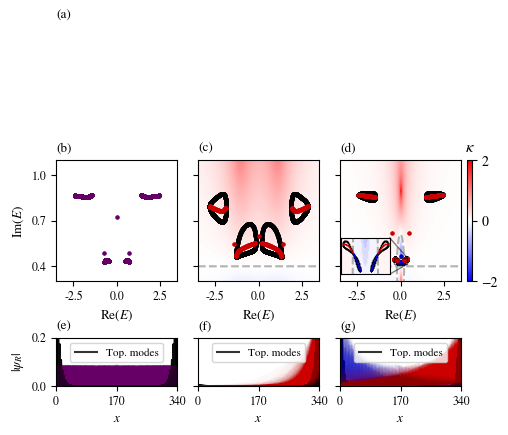

In [64]:
fig, ax= plt.subplots(2,3, figsize=(4.6,4))



#zorder for eigenstate plots
z1=1
z2=-10
alphb=0.8
alphs=0.015
alphaEo=1
alphaEp=1

fz = 9.5
ft = 8.5

#levels for contour plot
cr=2
levels=np.linspace(-cr,cr,19)

ca=np.asarray([0,0,0.8])
cb=np.asarray([0.8,0,0])

vmax=np.round(np.abs(eta2).max())+1

ax[0,1].imshow(np.transpose(eta2), alpha=1, cmap="bwr", zorder=-10, extent=(Er.min(), Er.max(), Ei.min(), Ei.max()), vmin=-vmax, vmax=vmax,origin='lower')
ax[0,1].set_aspect((Er.max()-Er.min())/(Ei.max()-Ei.min()))

c2=np.zeros([len(ee2),3])
for i in range(len(ee2)):
    c2[i,:]=ca+(1+np.sign(ee2[i]))/2*(cb-ca)
ax[0,1].plot(x, yb2, ls="--", color="gray", alpha=0.6)
ax[0,1].plot(x, yp2, ls="--", color="gray", alpha=0.6)
ax[0,1].plot(x, ym2, ls="--", color="gray", alpha=0.6)

ax[0,1].scatter(XYP2[:,0], XYP2[:,1], s=4, color="k", alpha=alphaEp,zorder=2)
for i in range(len(ee2)):
    ax[0,1].scatter(XYO2[i,0], XYO2[i,1], s=4, color=tuple(c2[i,:]), alpha=alphaEo, zorder=2)


temp = 0
for i in range(len(Y2)-1):
    if np.any(np.abs(EO2[i]-E002)<1e-3):
        if temp == 0:
            temp += 1
            ax[1,1].plot(Y2[:,i],color="k", alpha=alphb, zorder=z2, label = 'Top. modes');
        else :
            ax[1,1].plot(Y2[:,i],color="k", alpha=alphb, zorder=z2);
    elif np.any(c2[i,:]!=c2[i+1,:]):
        k=i
    else:
        kk=i
        ax[1,1].plot(Y2[:,i],color=tuple(c2[i,:]), alpha=alphs, zorder=z1);
ax[1,1].set_ylim(0,0.25)


c1=np.zeros([len(ee1),3])
for i in range(len(ee1)):
    c1[i,:]=ca+(1+np.sign(ee1[i]))/2*(cb-ca)
    
vmax2=np.round(np.abs(eta2).max())+1

cp1= ax[0,2].imshow(np.transpose(eta1), alpha=1, cmap="bwr", zorder=-10, extent=(Er.min(), Er.max(), Ei.min(), Ei.max()), vmin=-vmax2, vmax=vmax2,origin='lower')
ax[0,2].set_aspect((Er.max()-Er.min())/(Ei.max()-Ei.min()))

ax[0,2].plot(x, yb1, ls="--", color="gray", alpha=0.6)
ax[0,2].plot(x, yp1, ls="--", color="gray", alpha=0.6)
ax[0,2].plot(x, ym1, ls="--", color="gray", alpha=0.6)
ax[0,2].scatter(XYP1[:,0], XYP1[:,1], s=4, color="k", alpha=alphaEp,zorder=2)

axins = ax[0,2].inset_axes([0.01, 0.01, 1/2.5, 1/2.5])

axins.plot(x, yb1, ls="--", color="gray", alpha=0.6)
axins.plot(x, yp1, ls="--", color="gray", alpha=0.6)
axins.plot(x, ym1, ls="--", color="gray", alpha=0.6)
axins.scatter(XYP1[:,0], XYP1[:,1], marker=".", s=4, lw=0, color="k", alpha=alphaEp,zorder=2)

for i in range(len(ee1)):
    ax[0,2].scatter(XYO1[i,0], XYO1[i,1], s=4, color=tuple(c1[i,:]), alpha=alphaEo, zorder=2)
    axins.scatter(XYO1[i,0], XYO1[i,1], marker=".", s=4, lw=0, color=tuple(c1[i,:]), alpha=alphaEo, zorder=2)

    
axins.contourf(Er, Ei, eta1.T, levels = levels,cmap='bwr',alpha = 0.8)
# axins.contourf(np.transpose(eta1), alpha=0.6, cmap="bwr", zorder=-10, extent=(Er.min(), Er.max(), Ei.min(), Ei.max()), vmin=-vmax2, vmax=vmax2,origin='lower')
axins.set_aspect((Er.max()-Er.min())/(Ei.max()-Ei.min()))

axins.set_aspect(15)

# subregion of the original image
x1, x2, y1, y2 = -.4, .4, 0.415,0.455
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([])
axins.set_yticks([])

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
ax[0,2].indicate_inset_zoom(axins, edgecolor="black")

temp = 0
for i in range(len(Y1)-1):
    if np.any(np.abs(EO1[i]-E001)<1e-3):
        if temp == 0:
            temp += 1
            ax[1,2].plot(Y1[:,i],color="k", alpha=alphb, zorder=z2, label = 'Top. modes');
        else :
            ax[1,2].plot(Y1[:,i],color="k", alpha=alphb, zorder=z2);
        
    elif np.any(c1[i,:]!=c1[i+1,:]):
        k=i
    else:
        kk=i
        ax[1,2].plot(Y1[:,i],color=tuple(c1[i,:]), alpha=alphs, zorder=z1);
ax[1,2].set_ylim(0,0.25)


c3=np.zeros([len(ee3),3])
for i in range(len(ee3)):
    c3[i,:]=ca+(1+np.sign(ee3[i]))/2*(cb-ca)

l1, =ax[0,0].plot(x, yp3, ls="--", color="gray", alpha=0.8, label="$E_c$")
ax[0,0].plot(x, ym3, ls="--", color="gray", alpha=0.8)
l2=ax[0,0].scatter(XYP3[:,0], XYP3[:,1], s=4, color="k", alpha=alphaEp, zorder=2, label="PBC")
temp
for i in range(len(ee3)):
    k1=i
    k2=i-len(ee3)+1
    ax[0,0].scatter(XYO3[i,0], XYO3[i,1], s=4, color=(0.4,0,0.4), alpha=alphaEo, zorder=2, label="OBC")

temp = 0
for i in range(len(Y3)-1):
    if np.any(np.abs(EO3[i]-E003)<1e-3):
        if temp == 0:
            temp += 1
            ax[1,0].plot(Y3[:,i],color="k", alpha=alphb, zorder=z2);
            ax[1,0].plot(Y3[:,i]+200,color="k", alpha=alphb, zorder=z2, label = 'Top. modes')
        else :
            ax[1,0].plot(Y3[:,i],color="k", alpha=alphb, zorder=z2);
    elif np.any(c3[i,:]!=c3[i+1,:]):
        k=i
    else:
        kk=i
        ax[1,0].plot(Y3[:,i],color=(0.4,0,0.4), alpha=alphs, zorder=z1);
ax[1,0].set_ylim(0,0.25)

ax[1,0].legend( prop={'size': 8}, loc="upper center", fontsize=ft);
ax[1,1].legend( prop={'size': 8}, loc="upper center", fontsize=ft);
ax[1,2].legend(prop={'size': 8}, loc="upper center", fontsize=ft);

for i in range(3):
    ax[0,i].set_xlim(-3.5,3.5)
    ax[0,i].set_ylim(0.3,1.1)
    ax[1,i].set_ylim(0,0.25)
    ax[1,i].set_xlim(0,4*NcO-1)
    
    
xtik = np.linspace(-2.5, 2.5, 3)
ytik = np.linspace(0.4, 1, 3)
xlab = [f"{xtik[i]:.1f}" for i in range(len(xtik))]
ylab = [f"{ytik[i]:.1f}" for i in range(len(ytik))]
    
for axs in ax[0,0:3]:
    axs.set_xticks(xtik, xlab, fontsize=ft)
    axs.set_yticks(ytik, ylab, fontsize=ft)
    

xtik2 = np.linspace(0, len(Y2[:,0]), 3)
ytik2 = np.linspace(0, 0.25, 2)
xlab2 = [f"{xtik2[i]:.0f}" for i in range(len(xtik2))]
ylab2 = [f"{ytik2[i]:.1f}" for i in range(len(ytik2))]
    
for axs in ax[1,0:3]:
    axs.set_xticks(xtik2, xlab2, fontsize=ft)
    axs.set_yticks(ytik2, ylab2, fontsize=ft)


for axs in ax[0,0:3]:
    axs.set_xlabel("Re$(E)$", fontsize=fz)
ax[0,0].set_ylabel("Im$(E)$", fontsize=fz)
    
for axs in ax[1,0:3]:
    axs.set_xlabel("$x$", fontsize=fz)
ax[1,0].set_ylabel(r"$\left|\psi_R\right|$", fontsize=fz)

for axs in ax[0,0:3]:
    axs.set_aspect((Er.max()-Er.min())/(Ei.max()-Ei.min()))
for axs in ax[1,:]:
    axs.set_box_aspect(1/2.5)
    
for axs in ax[0,1:]:
    axs.yaxis.set_tick_params(labelleft=False)
for axs in ax[1,1:]:
    axs.yaxis.set_tick_params(labelleft=False)
    

    

# fig.delaxes(ax[1,3])

plt.tight_layout(pad=0, w_pad=0.5,  h_pad=-7)

pos = ax[0,0].get_position()
poss = ax[0,2].get_position()

cbar_ax = fig.add_axes([poss.x0+1.05*poss.width, poss.y0, 0.01, poss.height])
clb = plt.colorbar(cp1, cax=cbar_ax, ticks=[-vmax, 0, vmax])
clb.ax.set_title('$\kappa$');

imgadd=fig.add_axes([pos.x0, pos.y0+1.0*pos.height, poss.x0+poss.width-pos.x0, 1/3])
# imgadd.imshow(Image.open("SSHRedux.png"))
imgadd.set_xticks([])
imgadd.set_yticks([])
imgadd.set_frame_on(False)
imgadd.set_title('(a)',loc="left", fontsize=fz);

dicts={"(b)": ax[0,0], "(c)": ax[0,1], "(d)": ax[0,2], "(e)": ax[1,0], "(f)": ax[1,1], "(g)": ax[1,2]}

for key, axs in dicts.items():
    axs.set_title(key, loc='left', 
            fontsize=fz)
# plt.savefig("SSHFigsSmoothKappa.svg", dpi=600, bbox_inches="tight")

## Finding topological modes and calculating spectra as functions of parameters to probe the phase transitions

In [31]:
#%%
Nc=35 #number of cells
Nw=200 #number of w values

#parameters: b,t1,t2,t3
params1=(0.4, 0, 0.5, 0.6)
params2=(0.4, 1, 0.5, 0.6)
a=0.9
w=np.linspace(0,4,Nw)

#computing spectra and eigenstates

EE1=np.zeros([4*Nc,Nw], dtype=np.complex128)
EE2=np.zeros([4*Nc,Nw], dtype=np.complex128)

#Energy spectrum as a function of w
#for i in range(Nw):
#    EE1[:,i]=getspect(depcreutz(a, *params1, w[i], Nc, BC="open"))[0] #skin case

for i in tqdm(range(Nw)):
    EE2[:,i]=getspect(depcreutz(a, *params2, w[i], Nc, BC="open"))[0] #noskin case


#spectrum, left and right eigenstates at specific ww    
ww= 3;
E1, pl1, pr1 = getspect(depcreutz(a, *params1, ww, Nc, BC="open")) #skin case
E2, pl2, pr2 = getspect(depcreutz(a, *params2, ww, Nc, BC="open")) #noskin case


#biorthogonal wavefunction amplitudes
Pnh1=np.zeros([4*Nc,4*Nc], dtype=np.complex128)
Pnh2=np.zeros([4*Nc,4*Nc], dtype=np.complex128)
for i in range(4*Nc):
    Pnh1[:,i]=np.sqrt(np.conjugate(pl1[:,i])*pr1[:,i]/np.sum(np.conjugate(pl1[:,i])*pr1[:,i]))
    Pnh2[:,i]=np.sqrt(np.conjugate(pl2[:,i])*pr2[:,i]/np.sum(np.conjugate(pl2[:,i])*pr2[:,i]))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 36.71it/s]


In [32]:
# sorting real and imaginary eigenvalues

sEE1r=np.zeros([*np.shape(EE1)])
sEE1i=np.zeros([*np.shape(EE1)])
sEE2r=np.zeros([*np.shape(EE2)])
sEE2i=np.zeros([*np.shape(EE2)])
#for i in range(len(w)):
#    sEE1r[:,i]=np.sort(EE1[:,i].real)
#    sEE1i[:,i]=np.sort(EE1[:,i].imag)
#    sEE2r[:,i]=np.sort(EE2[:,i].real)
#    sEE2i[:,i]=np.sort(EE2[:,i].imag)

 

#Critical energies and intercell hoppings

sEE2r[:,0]= EE2[:,0].real
sEE2i[:,0]= EE2[:,0].imag

 

for i in tqdm(range(len(w)-1)):
    com = copy(EE2[:,i+1])
    for j in range(4*Nc):

        old = sEE2r[j,i] + 1j*sEE2i[j,i]

        dist = np.abs(com-old)

        idx = np.argmin(dist)

        sEE2r[j,i+1] = com[idx].real
        sEE2i[j,i+1] = com[idx].imag

        com[idx] = 10000


E001=Ecrit(a,*params1)
E002=Ecrit(a,*params2)

 
wc1=wcrit(a,*params1,E001)
wc2=wcrit(a,*params2,E002)

100%|███████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 750.14it/s]


In [33]:
#Edge mode exponential Envelopes


xiL1=-1/np.log(np.abs((vg(a,*params1,E001)[0]-vg(a,*params1,E001)[1])/ww))
xiL2=-1/np.log(np.abs((vg(a,*params2,E002)[0]-vg(a,*params2,E002)[1])/ww))

xiR1=-1/np.log(np.abs((vg(a,*params1,E001)[0]+vg(a,*params1,E001)[1])/ww))
xiR2=-1/np.log(np.abs((vg(a,*params2,E002)[0]+vg(a,*params2,E002)[1])/ww))


X=np.linspace(0,4*Nc,4*Nc)
env1=np.zeros([3,len(X)])
env2=np.zeros([3,len(X)])
env11=np.zeros([3,len(X)])
env22=np.zeros([3,len(X)])


for i in range(3):
    env1[i,:]=np.exp(-X*((xiL1[i]+xiR1[i])/(xiL1[i]*xiR1[i])/4))
    env2[i,:]=np.exp(-X*(xiL2[i]+xiR2[i])/(xiL2[i]*xiR2[i])/4)
    env11[i,:]=np.exp(-(4*Nc-X)*(xiL1[i]+xiR1[i])/(xiL1[i]*xiR1[i])/4)
    env22[i,:]=np.exp(-(4*Nc-X)*(xiL2[i]+xiR2[i])/(xiL2[i]*xiR2[i])/4)

In [35]:
#Winding number calculation

Wind1=np.zeros([Nw,3])
Wind2=np.zeros([Nw,3])

vc1=(TT(0,  *params1, E001)+TT(1,  *params1, E001))/2
gc1=(TT(0,  *params1, E001)-TT(1,  *params1, E001))/2

vc2=(TT(0,  *params2, E002)+TT(1,  *params2, E002))/2
gc2=(TT(0,  *params2, E002)-TT(1,  *params2, E002))/2

for e in range(3):
    for i in range(Nw):
        if w[i]>np.sqrt(np.abs(vc1[e]**2-gc1[e]**2)):
            Wind1[i,e]=1
        if w[i]>np.sqrt(np.abs(vc2[e]**2-gc2[e]**2)):
            Wind2[i,e]=1

## Plotting the mosaic figure with spectra and biorthogonal wavefunctions of the topological states

Please specify format you wish to save: pdf
Please specify name to save under: SSHFigsPhaseTransitions


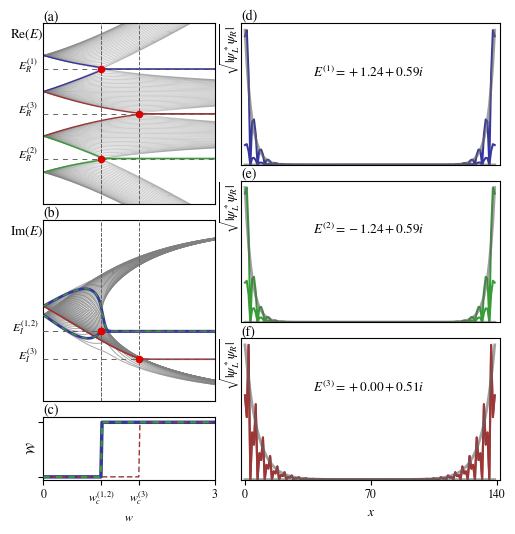

In [51]:
#Mosaic figure of the plots of spectra and biorthognal wavefunctions of the topoligcal modes

fig = plt.figure(constrained_layout=False, figsize=(4.96,5.144))
strings=[["fig2","edg21"],
            ["fig2","edg21"], ['fig2',"edg21"], ['fig2',"edg21"],
         ['fig2',"edg22"], ['Fig2',"edg22"], ['Fig2',"edg22"],['Fig2',"edg22"],
        ['Fig2',"edg23"],['Fig2',"edg23"],['Wnd2',"edg23"],['Wnd2',"edg23"]]

fz=9.5
ft=8.5
flg = 9.5

ax = fig.subplot_mosaic(strings,  gridspec_kw={'width_ratios': [2,3]})
# plt.subplots_adjust(wspace=0.4, hspace=1)

 
LW=0.7

idx1 = np.argmin(np.abs(np.real(sEE2r[:,-1])))
sEE2r[idx1,-1] += 1
idx2 = np.argmin(np.abs(np.real(sEE2r[:,-1])))
sEE2r[idx1,-1] += -1

idx3 = np.argmin(np.abs(np.real(sEE2r[:,-1]+1.41)))
sEE2r[idx3,-1] += 1
idx4 = np.argmin(np.abs(np.real(sEE2r[:,-1]+1.41)))
sEE2r[idx3,-1] += -1

idx5 = np.argmin(np.abs(np.real(sEE2r[:,-1]-1.41)))
sEE2r[idx5,-1] += 1
idx6 = np.argmin(np.abs(np.real(sEE2r[:,-1]-1.41)))
sEE2r[idx5,-1] += -1


LW2=1

cbulk=(128/255,128/255,128/255,0.4)
cedge1=(155/255,55/255,55/255,1)
cedge2=(55/255,155/255,55/255,1)
cedge3=(55/255,55/255,155/255,1)

C=[cedge3,cedge2,cedge1]



for i in range(4*Nc):
    if i==idx1:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge1, lw=LW2 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge1, lw=LW2 );
    elif i==idx2:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge1, lw=LW2 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge1, lw=LW2 );
    elif i==idx3:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge2, ls="--", dashes=(4, 4), lw=LW2, zorder=100 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge2, lw=LW2 );
    elif i==idx4:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge2, ls="--", dashes=(4, 4), lw=LW2, zorder=100 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge2, lw=LW2 );
    elif i==idx5:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge3, lw=LW2+1 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge3, lw=LW2 );
    elif i==idx6:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cedge3, lw=LW2+1 );
        ax['fig2'].plot(w, sEE2r[i,:], color=cedge3, lw=LW2 );
    else:
        ax['Fig2'].plot(w, sEE2i[i,:], color=cbulk, lw=LW,zorder = -100);
        ax['fig2'].plot(w, sEE2r[i,:], color=cbulk, lw=LW,zorder = -100);
    
zz=100
lw=0.7
SS=20
hexr="#DC0000FF"

 
# r,g,b=0/255,137/255,255/255
# C1=(r,g,b,0.8)
# C2=(0,0,0,0.8)
# C3=(1-r,1-g,1-b,0.8)

 
# C=[C1,C2,C3],

colordash=(100/255,100/255,100/255,1)
 
for i in range(3):  
    ax['Fig2'].axvline(wc2[i], color=colordash, ls="--", lw=lw, label="$w_{c}$", zorder=zz);
    ax['Fig2'].axhline(E002[i].imag, color=colordash, ls="--", dashes=(5, 5), lw=lw, label="$E_{t}$", zorder=zz);
    ax['Fig2'].scatter(wc2[i] ,E002[i].imag, s=SS, color=hexr, zorder=zz+1);

 
    ax['fig2'].axvline(wc2[i], color=colordash, ls="--", lw=lw, label="$w_{c}$", zorder=zz);
    ax['fig2'].axhline(E002[i].real, color=colordash, ls="--", lw=lw, dashes=(5, 5), label="$E_{t}$", zorder=zz);
    ax['fig2'].scatter(wc2[i] ,E002[i].real, s=SS, color=hexr, zorder=zz+1);

ax['fig2'].set_ylabel("Re$(E)$", fontsize=fz, loc="top", rotation = 0)
ax['fig2'].yaxis.set_label_coords(-0.0, 0.9)  # Adjust the coordinates as needed
ax['Fig2'].set_ylabel("Im$(E)$", fontsize=fz, loc="top", rotation = 0)
ax['Fig2'].yaxis.set_label_coords(-0.0, 0.9)  # Adjust the coordinates as needed

# colexp=(233/255,150/255,70/255,0.6)
colexp=(100/255,100/255,100/255,0.6)

for i in range(3):
    Y2=np.abs(Pnh2)[:,np.where(np.abs(E2-(E002[i]))<1e-2)[0]]
    ax['edg2{}'.format(i+1)].plot(Y2, color=C[i]);
    #Exponential Envelope plot
    ax['edg2{}'.format(i+1)].plot(np.max(Y2)*np.sqrt(env2[i,:]), lw=2, c=colexp)
    ax['edg2{}'.format(i+1)].plot(np.max(Y2)*np.sqrt(env22[i,:]), lw=2, c=colexp)
    if i!=1:
        ax['edg2{}'.format(i+1)].text(len(Pnh1)/3.7, 2*np.max(Y2[:,0])/3, "$E^{(%d)}=+%.2f+%.2fi$" %(i+1, np.real(E002[i])+0.0001, np.imag(E002[i])), fontsize=flg);
    else:
        ax['edg2{}'.format(i+1)].text(len(Pnh1)/3.7, 2*np.max(Y2[:,0])/3, "$E^{(%d)}=%.2f+%.2fi$" %(i+1, np.real(E002[i])+0.0001, np.imag(E002[i])), fontsize=flg);
    ax['edg2{}'.format(i+1)].yaxis.set_tick_params(labelleft=False)
    if i<2:
        ax['edg2{}'.format(i+1)].xaxis.set_tick_params(labelleft=False)
        ax['edg2{}'.format(i+1)].xaxis.set_ticks([])
        
        
        
for i in range(3):
    ax['edg2{}'.format(i+1)].set_ylabel("$\\sqrt{\\left|\psi_L^*\psi_R\\right|}$", fontsize=fz, labelpad=-0.1, loc="top")
ax['edg23'].set_xlabel("$x$", fontsize=fz);


xw1, xw2, yE1r, yE2r, yE1i, yE2i= -0.01, 3.01, -2.5, 2.5 , 0.4, 0.9

ax['fig2'].set_ylim(yE1r,yE2r);
ax['fig2'].set_xlim(xw1,xw2);
ax['Fig2'].set_ylim(yE1i,yE2i);
ax['Fig2'].set_xlim(xw1,xw2);


for i in range(3):
    ax['edg2{}'.format(i+1)].set_xlim(-2,4*Nc+2)
    ax['edg2{}'.format(i+1)].set_ylim(0,None)
    ax['edg2{}'.format(i+1)].set_yticks([])

    
xtik = np.linspace(0, 4*Nc, 3)   
xlab = [f"{xtik[i]:.0f}" for i in range(len(xtik))]
ax['edg23'.format(i+1)].set_xticks(xtik, xlab, fontsize=ft)


ax['Fig2'].xaxis.set_ticks([])
ax['fig2'].xaxis.set_ticks([])
ax['fig2'].yaxis.set_ticks([])
ax['Fig2'].yaxis.set_ticks([])

for i in range(3):
    ax["fig2"].text(-0.45,E002[i].real, "$E_R^{(%d)}$" %(i+1), fontsize=ft)
    if i>1:
        ax["Fig2"].text(-0.45,E002[i].imag, "$E_I^{(%d)}$" %(i+1), fontsize=ft)
    elif i==1:
        ax["Fig2"].text(-0.55,E002[i].imag, "$E_I^{(1,2)}$", fontsize=ft)
        
for i in range(3):
    if i==0:
        ax["Wnd2"].plot(w, Wind2[:,i], color=C[i], ls="-", lw=2.5, label= "$E_t=+{:.2f}+{:.2f}i$".format(E002[i].real+0.0001, E002[i].imag), zorder=i);
    elif i==1:
        ax["Wnd2"].plot(w, Wind2[:,i], color=C[i], ls="--", dashes=(3, 3), lw=1.5, label= "$E_t={:.2f}+{:.2f}i$".format(E002[i].real+0.0001, E002[i].imag), zorder=100);
    else:
        ax["Wnd2"].plot(w, Wind2[:,i], color=C[i], ls="--", dashes=(4, 2), lw=1, label= "$E_t=+{:.2f}+{:.2f}i$".format(E002[i].real+0.0001, E002[i].imag), zorder=i);


for i in range(1,2):
    ax["Wnd{}".format(i+1)].set_ylim([-0.05,1.1])
    ax["Wnd{}".format(i+1)].set_yticks([0,1])
    ax["Wnd{}".format(i+1)].set_xticks([0,wc2[0],wc2[2],3], ["0", "$w^{(1,2)}_c$", "$w_c^{(3)}$","3"], fontsize=ft)
    ax["Wnd{}".format(i+1)].set_xlim(-0.01,3.01)
    ax["Wnd{}".format(i+1)].set_xlabel("$w$", fontsize=ft);

ax["Wnd2"].set_ylabel("$\mathcal{W}$", fontsize=ft)


ax["Wnd2"].yaxis.set_tick_params(labelleft=False)




dicts={"(a)": ax["fig2"], "(b)": ax['Fig2'], "(c)": ax['Wnd2'],
      "(d)": ax["edg21"], "(e)": ax['edg22'], "(f)": ax['edg23'],}

for key, axs in dicts.items():
    title = axs.set_title(key,fontsize=10, loc="left", pad=2.5)



plt.tight_layout(pad=0, w_pad=0.0, h_pad=-0.2)

# plt.savefig("SSHFigsPhaseTransitionsnewnew.pdf", dpi=600, bbox_inches="tight")
# plt.savefig("SSHFigsPhaseTransitionsNEWNEW.png", dpi=600, bbox_inches="tight")

# filetype=".{}".format(input("Please specify format you wish to save: ")) 
# plt.savefig("{}".format(input("Please specify name to save under: "))+ filetype, dpi=600, bbox_inches="tight") 

# Calculating and spectrum and eigenstates of the Ns=10 ugly creutz model, with the nice parameter choice found from an earlier search


In [66]:
#Done for different w that show the appeareance of a different number of topological edge modes: 6 for w1 and 18 for w2

params= (1.1928048332191972, 3.7404523805411087, 1.1815608402386528, 2.9699303801115255, 4.243617811234085, 2.0283538918452506)
w1,w2=2.5,6.5;
NcO=30
Ns=10


EP1, plP1, prP1= getspect(uglycreutz8(*params, w1, 7*NcO, BC="periodic" ))
EO1, plO1, prO1= getspect(uglycreutz8(*params, w1, NcO, BC="open" ))

EP2, plP2, prP2= getspect(uglycreutz8(*params, w2, 7*NcO, BC="periodic" ))
EO2, plO2, prO2= getspect(uglycreutz8(*params, w2, NcO, BC="open" ))

XYP1=np.asarray([[np.real(EP1[i]), np.imag(EP1[i])] for i in range(len(EP1))])
XYO1=np.asarray([[np.real(EO1[i]), np.imag(EO1[i])] for i in range(len(EO1))])

XYP2=np.asarray([[np.real(EP2[i]), np.imag(EP2[i])] for i in range(len(EP2))])
XYO2=np.asarray([[np.real(EO2[i]), np.imag(EO2[i])] for i in range(len(EO2))])

#Biorthognal wavefunction amplitude
Y1=np.zeros([Ns*NcO,Ns*NcO], dtype=np.complex128)
for i in range(Ns*NcO):
    Y1[:,i]=np.conjugate(plO1[:,i])*prO1[:,i]/np.sum(np.conjugate(plO1[:,i])*prO1[:,i])

#right eigenstate amplitude
Yr1=np.sqrt(np.abs(prO1))

Y2=np.zeros([Ns*NcO,Ns*NcO], dtype=np.complex128)
for i in range(Ns*NcO):
    Y2[:,i]=np.conjugate(plO2[:,i])*prO2[:,i]/np.sum(np.conjugate(plO2[:,i])*prO2[:,i])

Yr2=np.sqrt(np.abs(prO2))


Ec=Ecrit10(*params)
w10c=w10crit(*params,Ec)

#aranging critical energies into their real and imaginary components
Ecd=[]
for i in range(len(Ec)):
    Ecd.append([Ec[i].real, Ec[i].imag])   
Ecd=np.asarray(Ecd)

In [67]:
#Creating the Kappa functions and the color coding for plotting eigenstates

M=300
Er1=np.linspace(np.min(EO1.real)-0.3, +np.max(np.abs(EO1.real))+0.3, M)
Ei1=np.linspace(np.min(EO1.imag)-0.3, +np.max(np.abs(EO1.imag))+0.3, M)

Er2=np.linspace(np.min(EO2.real)-0.3, +np.max(np.abs(EO2.real))+0.3, M)
Ei2=np.linspace(np.min(EO2.imag)-0.3, +np.max(np.abs(EO2.imag))+0.3, M)

ee1=np.log(np.sqrt(np.abs(TT10(1,  *params, EO1)/TT10(0,  *params, EO1))))
eta1=np.log(np.sqrt(np.abs(tt10(1,  *params, Er1,Ei1)/tt10(0,  *params, Er1,Ei1))))

ee2=np.log(np.sqrt(np.abs(TT10(1,  *params, EO2)/TT10(0,  *params, EO2))))
eta2=np.log(np.sqrt(np.abs(tt10(1,  *params, Er2,Ei2)/tt10(0,  *params, Er2,Ei2))))

Er1,Ei1=np.meshgrid(Er1, Ei1)
Er2,Ei2=np.meshgrid(Er2, Ei2)


ca=np.asarray([0,0,0.8])
cb=np.asarray([0.8,0,0])

c1=np.zeros([len(ee1),3])
for i in range(len(ee1)):
    c1[i,:]=ca+(1+np.sign(ee1[i]))/2*(cb-ca)
    
c2=np.zeros([len(ee2),3])
for i in range(len(ee2)):
    c2[i,:]=ca+(1+np.sign(ee2[i]))/2*(cb-ca)


## Plotting the results for the ugly creutz model

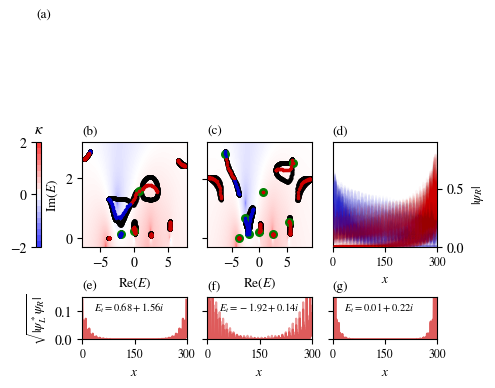

In [101]:
#Creating the plot with the model, the spectra and Kappa contours and a few topological edge modes.

fig, ax= plt.subplots(2,3,  figsize=(4.6,3.154285))
# plt.tight_layout(pad=0, w_pad=-1.8,  h_pad=-7.0)

alphs=0.02
alphaEp=1
alphaEo=1
z1=3

fz=9.5
ft=8.5

#levels for contour plot
cr=2
levels=np.linspace(-cr,cr,19)


ax[0,0].scatter(XYP1[:,0], XYP1[:,1], s=4, color="k", alpha=alphaEp, zorder=2);
ax[0,0].scatter(Ecd[np.where(w10c<2.2)][:,0], Ecd[np.where(w10c<2.2)][:,1], s=30, color="green", alpha=alphaEp, zorder=2);


for i in range(len(ee1)):
    ax[0,0].scatter(XYO1[i,0], XYO1[i,1], s=4, lw=0.5, color=tuple(c1[i,:]), alpha=alphaEo, zorder=2)


vmax1=np.round(np.abs(eta1).max())+1

cp0= ax[0,0].imshow(np.transpose(eta1), alpha= 1, cmap="bwr", zorder=-10, extent=(Er1.min(), Er1.max(), Ei1.min(), Ei1.max()), vmin=-vmax1, vmax=vmax1, origin='lower')
ax[0,0].set_aspect((Er1.max()-Er1.min())/(Ei1.max()-Ei1.min()))

    
# cp0= ax[0,0].contourf(Er1,Ei1,np.transpose(eta1), levels=levels, cmap="bwr", alpha=0.8, zorder=1)

ax[0,1].scatter(XYP2[:,0], XYP2[:,1], s=4, color="k", alpha=alphaEp, zorder=2);
ax[0,1].scatter(Ecd[:,0], Ecd[:,1], s=30, color="green", alpha=alphaEp, zorder=2);


for i in range(len(ee2)):
    ax[0,1].scatter(XYO2[i,0], XYO2[i,1], s=4, lw=0.5, color=tuple(c2[i,:]), alpha=alphaEo, zorder=2)

    
vmax2=np.round(np.abs(eta2).max())+1

cp0= ax[0,1].imshow(np.transpose(eta2), alpha= 1, cmap="bwr", zorder=-10, extent=(Er2.min(), Er2.max(), Ei2.min(), Ei2.max()), vmin=-vmax1, vmax=vmax2, origin='lower')
ax[0,1].set_aspect((Er2.max()-Er2.min())/(Ei2.max()-Ei2.min()))
# cp1= ax[0,1].contourf(Er2,Ei2,np.transpose(eta2), levels=levels, cmap="bwr", alpha=0.8, zorder=1)


for i in range(len(Yr1)-1):
    ax[0,2].plot(Yr1[:,i],color=tuple(c1[i,:]), alpha=alphs, zorder=z1);
    
for i in range(3):
    yy=np.abs(Y1)[:,np.where(np.abs(EO1-Ec[np.where(w10c<2.2)][i])<1e-2)[0]]
    ax[1,i].text(len(yy)/9, 0.1, "$E_t=%.2f+%.2fi$" %(np.real(Ec[np.where(w10c<2.2)][i]), np.imag(Ec[np.where(w10c<2.2)][i])), fontsize=ft-1);
    ax[1,i].plot(yy, color=(0.8,0,0,0.4));

xtik = np.linspace(0, Ns*NcO, 3)
# ytik = np.linspace(0.4, 1, 3)
xlab = [f"{xtik[i]:.0f}" for i in range(len(xtik))]
ax[0,2].set_xticks(xtik, xlab, fontsize=ft)
for axs in ax[1,0:3]:
    axs.set_xticks(xtik, xlab, fontsize=ft)
    
for axs in ax[0,0:2]:
    axs.set_xlabel("Re$(E)$", fontsize=fz)
ax[0,0].set_ylabel("Im$(E)$", fontsize=fz)
# ax[0,0].yaxis.set_label_position("right")


ax[0,2].set_ylabel(r"$\left|\psi_R\right|$", fontsize=fz)
ax[0,2].yaxis.set_label_position("right")
ax[0,2].yaxis.tick_right()
ax[0,2].set_xlabel("$x$", fontsize=fz)
ax[0,2].set_xlim(0,Ns*NcO)
ax[0,2].set_ylim(0,0.9)
    
for axs in ax[1,0:3]:
    axs.set_xlabel("$x$", fontsize=fz)
ax[1,0].set_ylabel(r"$\sqrt{\left|\psi^*_L\psi_R\right|}$", fontsize=fz)

for axs in ax[0,0:3]:
    axs.set_box_aspect(1)
for axs in ax[1,:]:
    axs.set_box_aspect(1/2.5)
    

    

ax[0,1].yaxis.set_tick_params(labelleft=False)
for axs in ax[1,1:]:
    axs.yaxis.set_tick_params(labelleft=False)
    
for i in range(3):
    ax[1,i].set_ylim(0,0.15)
    ax[1,i].set_xlim(-0.2, Ns*NcO)
    
    
plt.tight_layout(pad=0, w_pad=0.5,  h_pad=-5)

poss = ax[0,0].get_position()
pos = ax[0,2].get_position()
cbar_ax = fig.add_axes([poss.x0-0.1, poss.y0, 0.01, poss.height])

# cbar_ax = fig.add_axes([poss.x0, poss.height+0.9*poss.y0, poss.width, 0.06*poss.height])
clb = plt.colorbar(cp1, cax=cbar_ax, ticks=[-cr, 0, cr])
clb.ax.set_title('$\kappa$');
cbar_ax.yaxis.set_ticks_position('left')


imgadd=fig.add_axes([poss.x0-0.1, poss.y0+0.9*poss.height, pos.x0+pos.width-poss.x0+0.15, 1/2.5])
# imgadd.imshow(Image.open("UglyCreutz1.png"))
imgadd.set_xticks([])
imgadd.set_yticks([])
imgadd.set_frame_on(False)
imgadd.set_title('(a)',loc="left", fontsize=fz);
    
dicts={"(b)": ax[0,0], "(c)": ax[0,1], "(d)": ax[0,2], "(e)": ax[1,0], "(f)": ax[1,1], "(g)": ax[1,2]}

for key, axs in dicts.items():
    axs.set_title(key, loc='left', 
            fontsize=fz)
plt.savefig("Ugly10Creutz.svg", dpi=600, bbox_inches="tight")